In [10]:
from rdkit import Chem
import re
import json

def convert_sdf2smi(filename, sdf_filepath, smi_filepath):
    supplier = Chem.SDMolSupplier(sdf_filepath+filename)
    smiles_list = []
    
    for mol in supplier:
        if mol is None:
            raise ValueError(f'there is no molecule in the file: {filename}!')
        else:
            smiles = Chem.MolToSmiles(mol)
            smiles_escaped = re.sub(r'\\', r'\\\\', smiles)
            smiles_list.append(smiles_escaped)
        if len(smiles_list) > 1:
            raise ValueError(f'file {filename} contains more than 1 molecules!')
            #print(filename)
    # dump smile info to smi file
    with open(smi_filepath+f'{filename}.smi', 'w') as f:
        #json.dump(smiles_list,f)
        f.write('\n'.join(smiles_list))

    return smiles_list    

In [12]:
# exacuation

import os

which_project = '005'
sdf_dir = './selected_sdfs/'
smi_dir = './selected_smis/'

filenames = sorted(os.listdir(sdf_dir))
sdf_filenames_list = [f for f in filenames]

smi_file_path = smi_dir + f'all_{which_project}.smi'
if os.path.exists(smi_file_path):
    os.remove(smi_file_path)
    
for i,file in enumerate(sdf_filenames_list):
    smiles = convert_sdf2smi(file, sdf_dir, smi_dir)
    with open(smi_file_path, 'a') as all:
        all.write('\n'.join(smiles)+'\n')

In [14]:
len(sdf_filenames_list)

22

In [22]:
import pandas as pd

smis = pd.read_csv(smi_dir+f'all_{which_project}.smi', sep='\t',header=None)
smis[0][1]

'CC(=O)N[C@H](CSSC[C@H]([NH3+])C(=O)[O-])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(N)=O'

In [24]:
#selection_lt = [0,1,17,20,27,28,32,35,36,40,41,42,44,48,50,56,57,60,61,65,70,71]
com_name = ['3',   '2',     '4a',   '4b',   '5e',   '5f',   '5a',   '4d',   '4c',   '6a',   '6d',   '6e',   '4e',   '6g',   '6f',   '5d',   '5b',   '5c',   '5g',   '5h',   '6b',  '6c']
dg =       [-55.10, -43.86, -68.69, -68.61, -65.52, -70.44, -71.70, -58.01, -63.53, -36.50, -40.37, -48.11, -69.74, -59.38, -49.85, -78.45, -60.55, -77.59, -66.32, -57.30, -34.48, -34.02]
affinity = [2.03, 12.75, 1.23, 0.27, 0.5, 0.44, 0.3, 1.65, 2.09, 2.91, 2.36, 6.26, 0.59, 1.45, 1.6, 0.71, 0.41, 0.53, 0.89, 1.17, 9.61, 42.43]

print(len(dg))
print(len(com_name))
print(len(affinity))
print(len(smis))
#data_smi = pd.read_csv('data_smiles.csv', sep=',', header=0)

with open('paper_data_smiles.csv','w') as ps:
    ps.write('idx'+','+'smiles'+','+'dG'+','+'affinity'+'\n')
    for i,idx in enumerate(com_name):
        ps.write(com_name[i]+','+smis[0][i]+','+str(dg[i])+','+str(affinity[i])+'\n')
    #ps.close()    

22
22
22
22


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from sklearn.decomposition import PCA

# 1. 计算物理化学描述符
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # 提取常用描述符
    desc_dict = {
        'MW': Descriptors.MolWt(mol),  # 分子量
        'LogP': Descriptors.MolLogP(mol),  # 脂水分配系数
        'HBD': Descriptors.NumHDonors(mol),  # 氢键供体数
        'HBA': Descriptors.NumHAcceptors(mol),  # 氢键受体数
        'TPSA': Descriptors.TPSA(mol),  # 拓扑极表面积
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),  # 重原子数
        'RingCount': Descriptors.RingCount(mol),  # 环数
    }
    return desc_dict

# 2. 计算ECFP指纹
def calculate_ecfp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

# 3. 计算MACCS指纹
def calculate_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MACCSkeys.GenMACCSKeys(mol)

# 4. 执行PCA
def perform_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)
    return principal_components, pca

In [ ]:
import numpy as np

pca_data = pd.read_csv('paper_data_smiles.csv', sep=',', header=0)

# 转换为特征矩阵
descriptors_list = []
ecfp_list = []
maccs_list = []

for smiles in pca_data['smiles']:
    desc = calculate_descriptors(smiles)
    if desc:
        descriptors_list.append(desc)
        
        ecfp = calculate_ecfp(smiles)
        ecfp_list.append(np.array(ecfp))
        
        maccs = calculate_maccs(smiles)
        maccs_list.append(np.array(maccs))

# 构建特征矩阵
df_desc = pd.DataFrame(descriptors_list)
X_desc = df_desc.values  # 物理化学描述符矩阵

X_ecfp = np.array(ecfp_list)  # ECFP指纹矩阵
X_maccs = np.array(maccs_list)  # MACCS指纹矩阵

# 对不同特征矩阵分别进行PCA
pc_desc, pca_desc = perform_pca(X_desc)
pc_ecfp, pca_ecfp = perform_pca(X_ecfp)
pc_maccs, pca_maccs = perform_pca(X_maccs)


(22, 1024)


[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerator
[16:59:53] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
print(X_ecfp.shape)

(22, 1024)


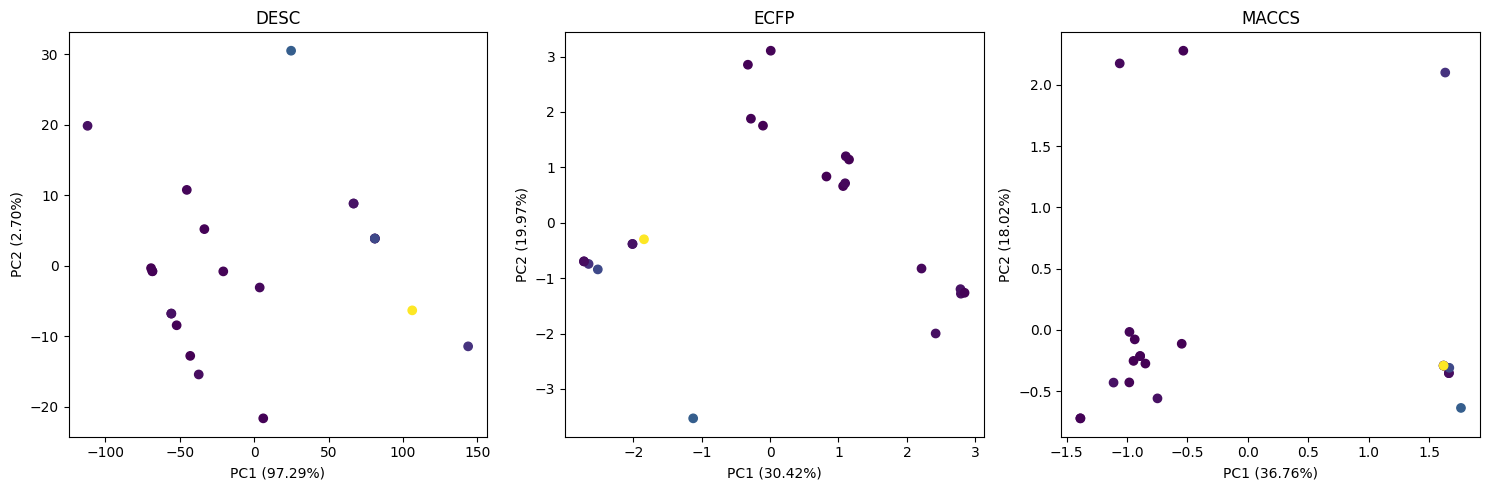

In [ ]:
import matplotlib.pyplot as plt

color = pca_data['affinity']

# 5. 可视化结果
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(pc_desc[:, 0], pc_desc[:, 1], c=color)
plt.title('DESC')
plt.xlabel(f'PC1 ({pca_desc.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_desc.explained_variance_ratio_[1]:.2%})')

plt.subplot(1, 3, 2)
plt.scatter(pc_ecfp[:, 0], pc_ecfp[:, 1], c=color)
plt.title('ECFP')
plt.xlabel(f'PC1 ({pca_ecfp.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_ecfp.explained_variance_ratio_[1]:.2%})')

plt.subplot(1, 3, 3)
plt.scatter(pc_maccs[:, 0], pc_maccs[:, 1], c=color)
plt.title('MACCS')
plt.xlabel(f'PC1 ({pca_maccs.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_maccs.explained_variance_ratio_[1]:.2%})')

plt.tight_layout()
plt.show()

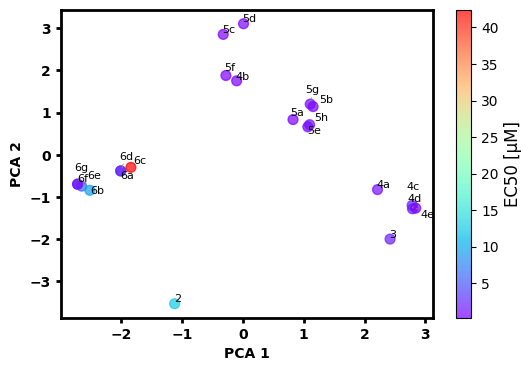

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

color_values = pca_data['affinity']
labels = [l for l in pca_data['idx']]

fig, ax = plt.subplots(figsize=(6, 4))
# 4. 绘制散点图，用最后一列的值着色
scatter = ax.scatter(
    #pc_desc[:, 0], pc_desc[:, 1],
    pc_ecfp[:, 0], pc_ecfp[:, 1],
    #pc_maccs[:, 0], pc_maccs[:, 1],
    c=color_values,  # 使用最后一列的值作为颜色
    cmap='rainbow',  # 颜色映射方案（可更换，如'plasma', 'jet'等）
    alpha=0.7,       # 点的透明度
    s=50             # 点的大小
)


# 收集所有标签对象
texts = []
for i in range(pca_data.shape[0]):
    # 先将所有标签添加到列表
    texts.append(ax.text(pc_ecfp[i, 0], pc_ecfp[i, 1], labels[i], fontsize=8))


# 自动调整标签位置以避免重叠
adjust_text(
    texts,
    x=pc_ecfp[i, 0], y=pc_ecfp[i, 1],  # 数据点坐标，用于碰撞检测
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)  # 可选：添加指向线
)

# 5. 添加颜色条（colorbar）
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('EC50 [μM]', fontsize=12)  # 设置colorbar标签

ax.set_xlabel('PCA 1',fontweight='bold')
ax.set_ylabel('PCA 2',fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(2.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度
#plt.margins(0.01)

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')


#ax.set_title('带标签的PCA聚类图')
plt.show()
fig.savefig('./imgs/pca.png', dpi=300, bbox_inches='tight')

### QSAR

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

# ===============================
# 1. 载入数据
# 假设你已有 X (PCA后的特征) 和 y (EC50)，这里示例从CSV读取
# ===============================
# X = pd.read_csv('features_pca.csv').values  # shape (n_samples, n_features)
# y = pd.read_csv('ec50.csv').values.flatten()

# 如果未转 pEC50，建议转换
# y = -np.log10(y * 1e-6)  # IC50/EC50 转换成 mol/L 并取 -log10

# ===============================
# 2. 划分训练集和测试集
# ===============================

import numpy as np

X = pc_ecfp
y = pca_data['affinity'] # Unit uM

pEC50 = 6 - np.log(y) 

X_train, X_test, y_train, y_test = train_test_split(
    X, pEC50, test_size=0.2, random_state=42
)

# ===============================
# 3. 构建 XGBoost 模型
# ===============================
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# ===============================
# 4. 模型训练
# ===============================
model.fit(X_train, y_train)

# ===============================
# 5. 模型预测与评估
# ===============================
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

# ===============================
# 6. 交叉验证 (可选)
# ===============================
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"Cross-val R²: {scores.mean():.3f} ± {scores.std():.3f}")

# ===============================
# 7. 保存模型
# ===============================
#joblib.dump(model, 'qsar_xgb_model.pkl')
#print("Model saved to qsar_xgb_model.pkl")

# 加载模型方法
# model = joblib.load('qsar_xgb_model.pkl')


Test RMSE: 0.423
Test R²: 0.535
Cross-val R²: -7.783 ± 13.522


In [17]:
joblib.dump(model, 'qsar_xgb_model.pkl')

['qsar_xgb_model.pkl']

In [18]:
pEC50

0     5.291964
1     3.454469
2     5.792986
3     7.309333
4     6.693147
5     6.820981
6     7.203973
7     5.499225
8     5.262836
9     4.931847
10    5.141338
11    4.165820
12    6.527633
13    5.628436
14    5.529996
15    6.342490
16    6.891598
17    6.634878
18    6.116534
19    5.842996
20    3.737196
21    2.252144
Name: affinity, dtype: float64

In [ ]:
### QSAR from colab: https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/ml_models/QSAR_in_8_lines.ipynb#scrollTo=ad300921

In [25]:
import pandas as pd
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from yellowbrick.regressor import prediction_error, residuals_plot

In [31]:
# 1. Read data from csv
df = pd.read_csv('paper_data_smiles.csv', sep=',', header=0)
df.smiles.values

array(['CC(=O)N[C@H](CS)C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(N)=O',
       'CC(=O)N[C@H](CSSC[C@H]([NH3+])C(=O)[O-])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(N)=O',
       'CC(=O)N[C@H](CS)C(=O)N[C@H](C)C(=O)N[C@H](Cc1ccc(NC(N)=[NH2+])cc1)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(N)=O',
       'CC(=O)N[C@H](C[S-])C(=O)N[C@H](C)C(=O)N[C@H](Cc1cccc(NC(N)=[NH2+])c1)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(N)=O',
       'CC(=O)N[C@H](CS)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](Cc1cccc(NC(N)=[NH2+])c1)C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](C)C(=O)N[C@H](CCCNC(N)=[NH2+])C(N)=O',
       'CC(=O)N[C@H](C[S-])C(=O)N[C@H](CCCNC(N)=[NH2+])C(=O)N[C@H](Cc1cccc(NC(N)=[NH

In [38]:
df

,idx,smiles,dG,affinity,fp
0,3,CC(=O)N[C@H](CS)C(=O)N[C@H](C)C(=O)N[C@H](CCCN...,-55.1,2.03,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,CC(=O)N[C@H](CSSC[C@H]([NH3+])C(=O)[O-])C(=O)N...,-43.9,12.75,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,4a,CC(=O)N[C@H](CS)C(=O)N[C@H](C)C(=O)N[C@H](Cc1c...,-68.7,1.23,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4b,CC(=O)N[C@H](C[S-])C(=O)N[C@H](C)C(=O)N[C@H](C...,-34.9,0.27,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5e,CC(=O)N[C@H](CS)C(=O)N[C@H](CCCNC(N)=[NH2+])C(...,-65.5,0.50,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,5f,CC(=O)N[C@H](C[S-])C(=O)N[C@H](CCCNC(N)=[NH2+]...,-26.1,0.44,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,5a,CC[C@@H](NC(=O)[C@@H](Cc1cccc(NC(N)=[NH2+])c1)...,-71.7,0.30,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,4d,CC(=O)N[C@H](CS)C(=O)N[C@H](C)C(=O)N[C@H](Cc1c...,-58.0,1.65,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,4c,CC(=O)N[C@H](CS)C(=O)N[C@H](C)C(=O)N[C@H](Cc1c...,-63.5,2.09,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,6a,CC(=O)N[C@H](CSSC[C@H](N)C(=O)[O-])C(=O)N[C@H]...,-36.5,2.91,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [27]:
# 2. Instantiate a Fingerprint calculator from the awesome molfeat package. This package has several descriptor types available.

from molfeat.calc import FP_FUNCS
FP_FUNCS.keys()

dict_keys(['maccs', 'avalon', 'pattern', 'layered', 'map4', 'secfp', 'erg', 'estate', 'avalon-count', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'ecfp-count', 'fcfp-count', 'topological-count', 'atompair-count', 'rdkit-count'])

In [28]:
calc = FPCalculator("ecfp")

In [29]:
# 3. Instantiate a molecule transfomer from molfeat. 
# This object takes a list of SMILES as input and returns descriptors. 
# It's very flexible and can run in parallel. Check it out!

trans = MoleculeTransformer(calc)

In [32]:
# 4-5. Calculate the fingerprints. Note the use of the function from datamol that silences logging messages from the RDKit. 
# This is more polite version of my rd_shut_the_hell_up function in useful_rdkit_utils.

with dm.without_rdkit_log():
    df['fp'] = trans.transform(df.smiles.values)

/home/share/software/anaconda3-202406/envs/abs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
# 6. Split the data into training and test sets. I like to do this with dataframes. 
# That way I don't have to remember the order in which train_X, test_X, train_y, and test_y are returned by train_test_split

train, test = train_test_split(df)

In [36]:
# 7. Instantiate an sklearn style regressor. In this case I used HistGradientBoostingRegressor, which is the scikit-learn implementation of LightGBM. 
# You can easily plug in any scikit-learn compatible regressor like RandomForest or XGBoost.
from lightgbm import LGBMRegressor
model = LGBMRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from xgboost import XGBRegressor


In [51]:
model = XGBRegressor()
#model = HistGradientBoostingRegressor()

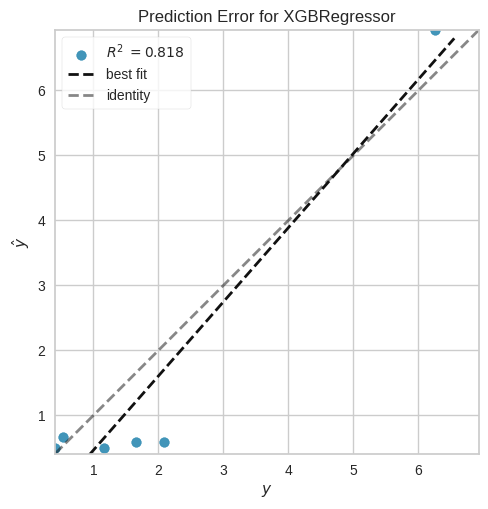

<Figure size 800x550 with 0 Axes>

In [52]:
# 8. Use YellowBrick to build a model and visualize its performance. The Loss reported in the plot below is the  R2  for the model.

visualizer = prediction_error(model,np.stack(train.fp),train.affinity,np.stack(test.fp),test.affinity)
visualizer.fig.savefig("./imgs/prediction_error.png", dpi=300, bbox_inches='tight')

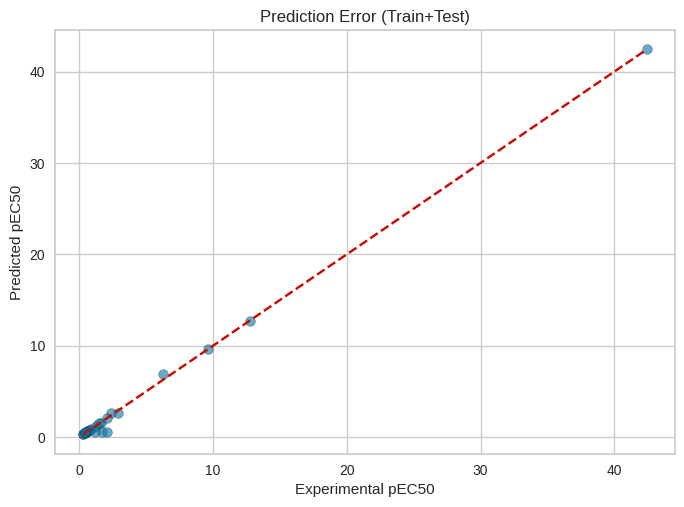

In [46]:
# 合并 train 和 test
X_all = np.vstack([np.stack(train.fp), np.stack(test.fp)])
y_all = np.concatenate([train.affinity, test.affinity])

# 重新预测
y_pred_all = model.predict(X_all)

# 画散点图
import matplotlib.pyplot as plt

plt.scatter(y_all, y_pred_all, alpha=0.6, edgecolor='k')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--')  # identity line
plt.xlabel("Experimental pEC50")
plt.ylabel("Predicted pEC50")
plt.title("Prediction Error (Train+Test)")
plt.show()


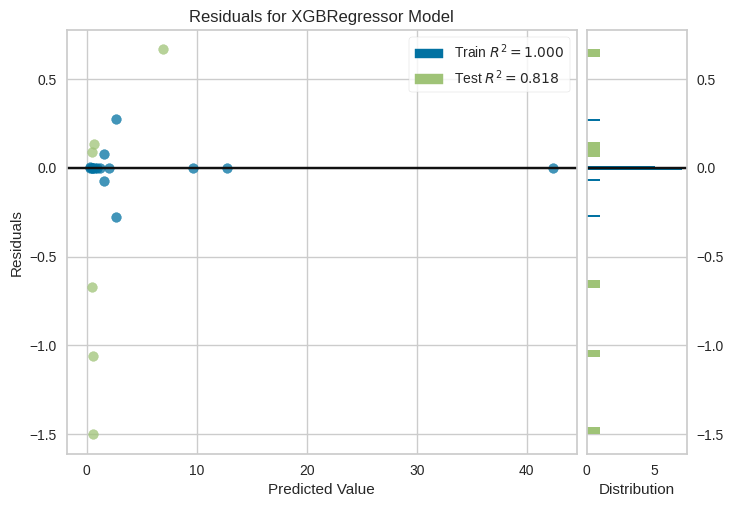

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

<Figure size 800x550 with 0 Axes>

In [48]:
### Bonus
### Plot the residuals for the training and test sets

viz = residuals_plot(model,np.stack(train.fp), train.affinity, np.stack(test.fp), test.affinity, is_fitted=True)
viz.show(outpath="./imgs/residual_plot.png") 

In [35]:
!pip install lightgbm -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 17.4 MB/s eta 0:00:00a 0:00:01


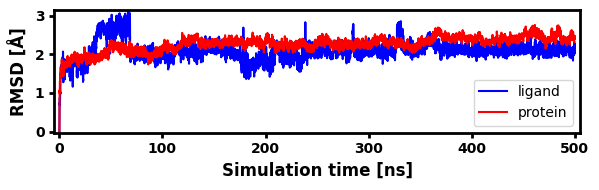

In [158]:
### rmsd plot

import matplotlib.pyplot as plt
import numpy as np

rmsd_lig = np.loadtxt('./rmsd/rmsd-lig.dat')
rmsd_pro = np.loadtxt('./rmsd/rmsd-pro.dat')
frame = rmsd_lig[:,0]
rmsd_lig_val = rmsd_lig[:,1]
rmsd_pro_val = rmsd_pro[:,1]


fig, ax = plt.subplots(figsize=(6, 2))  # 设置图形大小

# 绘制曲线
ax.plot(frame/10, rmsd_lig_val, linestyle='-', color='b', label='ligand')
ax.plot(frame/10, rmsd_pro_val, linestyle='-', color='r', label='protein')

# 添加标题和坐标轴标签
ax.set_xlabel('Simulation time [ns]', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSD [Å]', fontsize=12, fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(2.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# 调整布局并显示图形
plt.tight_layout()
plt.margins(0.01)
plt.legend()
plt.show()
fig.savefig('./imgs/rmsd_pro_lig.png', dpi=300, bbox_inches='tight')

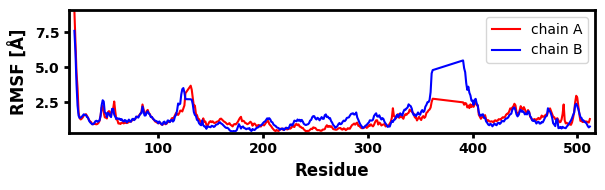

In [157]:
import pandas as pd

rmsf_pro = pd.read_csv('./rmsf/rmsf_pro_ecd.csv',header=0,sep=',')
#rmsf_pro

fig, ax = plt.subplots(figsize=(6, 2))  # 设置图形大小

# 绘制曲线
ax.plot(rmsf_pro[rmsf_pro['chain']=='A']['resdue'], rmsf_pro[rmsf_pro['chain']=='A']['rmsf'], color='r', label='chain A')
ax.plot(rmsf_pro[rmsf_pro['chain']=='B']['resdue'], rmsf_pro[rmsf_pro['chain']=='B']['rmsf'], color='b', label='chain B')

# 添加标题和坐标轴标签
ax.set_xlabel('Residue', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSF [Å]', fontsize=12, fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(2.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

# 调整布局并显示图形
plt.tight_layout()
plt.margins(0.01)
plt.legend()
plt.show()
fig.savefig('./imgs/rmsf_pro.png', dpi=300, bbox_inches='tight')

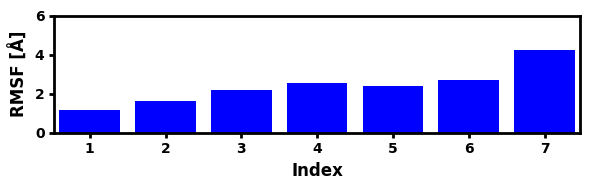

In [180]:
rmsf_lig = np.loadtxt('./rmsf/rmsf_lig.dat')
rmsf_lig_idx = [1,2,3,4,5,6,7]
rmsf_lig_val = [1.16, 1.64, 2.21, 2.55, 2.38, 2.68, 4.25]

fig, ax = plt.subplots(figsize=(6, 2))  # 设置图形大小

# 绘制曲线
ax.bar(rmsf_lig_idx, rmsf_lig_val, color='b')
#ax.plot(frame/10, rmsd_pro_val, linestyle='-', color='r', label='protein')

# 添加标题和坐标轴标签
ax.set_xlabel('Index', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSF [Å]', fontsize=12, fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(2.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.ylim(0,6)

# 调整布局并显示图形
plt.tight_layout()
plt.margins(0.01)
#plt.legend()
plt.show()
fig.savefig('./imgs/rmsf_lig.png', dpi=300, bbox_inches='tight')

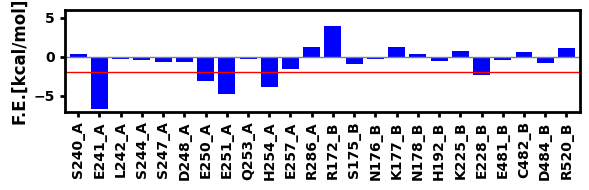

In [173]:
fed = pd.read_csv('./energy_decomposition/fed.csv',header=0)

fig, ax = plt.subplots(figsize=(6, 2))  # 设置图形大小

# 绘制曲线
ax.bar(fed['Residue'], fed['Total'], color='b')
#ax.plot(frame/10, rmsd_pro_val, linestyle='-', color='r', label='protein')

ax.axhline(
    y=0.0,  # Y-position of the line
    color='gray',  # Line color
    linewidth=1,  # Line thickness
)

ax.axhline(
    y=-2,  # Y-position of the line
    color='red',  # Line color
    linewidth=1,  # Line thickness
)


# 添加标题和坐标轴标签
#ax.set_xlabel('Index', fontsize=12, fontweight='bold')
ax.set_ylabel('F.E.[kcal/mol]', fontsize=12, fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(2.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
plt.xticks(fontsize=10, fontweight='bold',rotation=90)
plt.yticks(fontsize=10, fontweight='bold')

plt.ylim(-7,6)

# 调整布局并显示图形
plt.tight_layout()
plt.margins(0.01)
#plt.legend()
plt.show()
fig.savefig('./imgs/fed.png', dpi=300, bbox_inches='tight')

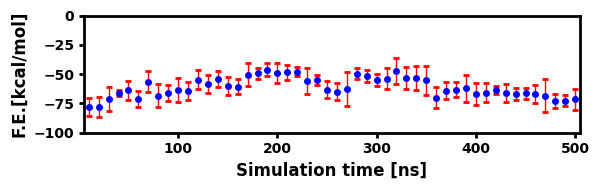

In [175]:
### free energy convergence

fec = np.loadtxt('./energy_decomposition/free_energy_convergence.dat')

fig, ax = plt.subplots(figsize=(6, 2.))  # 设置图形大小


# Plot error bars
ax.errorbar(
    fec[:,0],fec[:,1],
    yerr=fec[:,2],        # Error bars for y-axis
    #xerr=x_errors,        # Error bars for x-axis (optional)
    fmt='o',              # Marker style (circle in this case)
    ecolor='red',         # Color of error bars
    elinewidth=1,         # Width of error bars
    capsize=2,            # Length of error bar caps
    capthick=2,           # Thickness of error bar caps
    color='blue',         # Color of data points
    markersize=4,         # Size of data point markers
    label='Data with errors'
)

# 添加标题和坐标轴标签
ax.set_xlabel('Simulation time [ns]', fontsize=12, fontweight='bold')
ax.set_ylabel('F.E.[kcal/mol]', fontsize=12, fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(2.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.ylim(-100,0)

# 调整布局并显示图形
plt.tight_layout()
plt.margins(0.01)
#plt.legend()
plt.show()
fig.savefig('./imgs/fec.png', dpi=300, bbox_inches='tight')

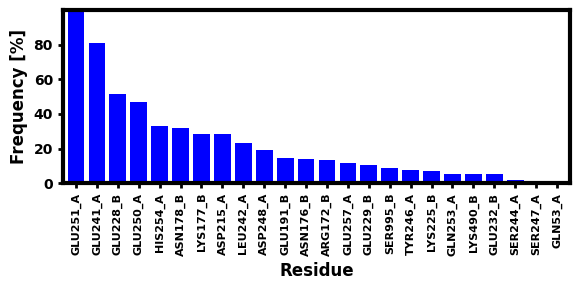

In [178]:
### hydrogen bonds

hb = pd.read_csv('./energy_decomposition/hydrogen_bonds.csv',header=0)

fig, ax = plt.subplots(figsize=(6, 3))  # 设置图形大小

# 绘制曲线
ax.bar(hb['Residue'], hb['frequency'], color='b')
#ax.plot(frame/10, rmsd_pro_val, linestyle='-', color='r', label='protein')

# 添加标题和坐标轴标签
ax.set_xlabel('Residue', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency [%]', fontsize=12, fontweight='bold')

# 加粗边框
for spine in ax.spines.values():
    spine.set_linewidth(3.0) 

# 加粗刻度线
ax.xaxis.set_tick_params(width=2)  # x轴刻度线宽度
ax.yaxis.set_tick_params(width=2)  # y轴刻度线宽度

# 加粗轴上的数值（兼容旧版本Matplotlib的方式）
ax.set_yticks([0, 20, 40, 60, 80, 100])
plt.xticks(fontsize=8, fontweight='bold', rotation=90)
plt.yticks(fontsize=10, fontweight='bold')

#plt.ylim(0,6)

# 调整布局并显示图形
plt.tight_layout()
plt.margins(0.01)
#plt.legend()
plt.show()
fig.savefig('./imgs/hydrogen_bonds.png', dpi=300, bbox_inches='tight')